In [7]:
!pip install category_encoders
!pip install xfeat
!pip install texthero

     |████████████████████████████████| 245kB 6.1MB/s 
     |████████████████████████████████| 1.4MB 9.0MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp36-none-any.whl size=1434677 sha256=07743b10c81b62b4a612ba69154a5f95d3818e66d0486ce3f29ca27df0472449
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [8]:
import os 
import re
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.optimize import minimize

from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import category_encoders as ce
import xfeat
import texthero as hero
from lightgbm import LGBMModel

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
warnings.filterwarnings("ignore")

INPUT = "../input"
SUBMISSION = "../submission"
NAME = "baseline001"
FOLDS = 5  # kfoldの数

In [10]:
# notebookで横に表示するやつ -> signateで表示バグ
class HorizontalDisplay:
    def __init__(self, *args):
        self.args = args

    def _repr_html_(self):
        template = '<div style="float: left; padding: 10px;">{0}</div>'
        return "\n".join(template.format(arg._repr_html_())
                         for arg in self.args)

In [11]:
train = pd.read_csv('/content/drive/MyDrive/SIGNATE/DATASET/train.csv')
test = pd.read_csv('/content/drive/MyDrive/SIGNATE/DATASET/test.csv')
train.head().T

,0,1,2,3,4
id,0,1,2,3,4
goal,4001-5000,3001-4000,19001-20000,2001-3000,2001-3000
country,CH,NL,US,US,GB
duration,29,34,30,41,29
category1,publishing,fashion,food,technology,technology
category2,young adult,ready-to-wear,spaces,3d printing,diy electronics
html_content,"<div class=""contents""><div><span class=""bold"">...","<div class=""contents""><div><h1 class=""page-anc...","<div class=""contents""><div><p> As our society ...","<div class=""contents""><div><p>My name is Donal...","<div class=""contents""><div><div class=""templat..."
state,0,0,0,0,1


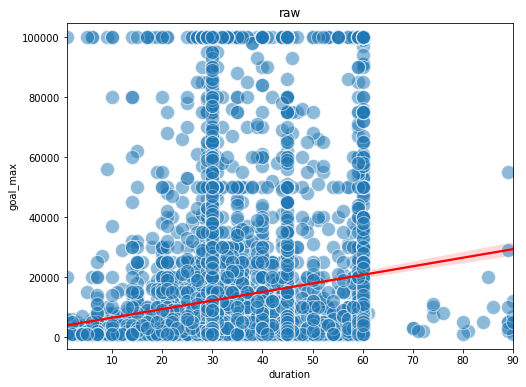

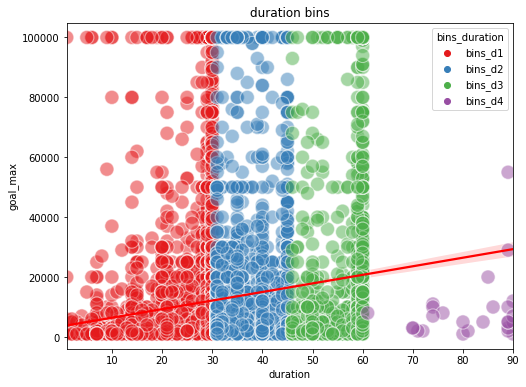

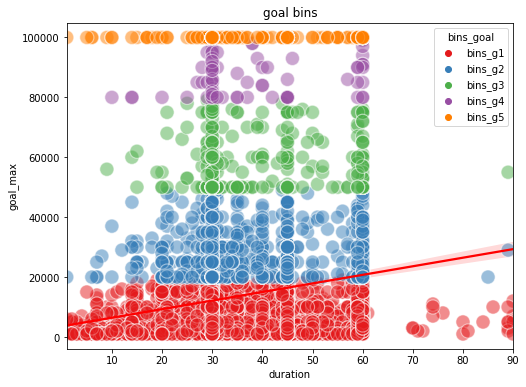

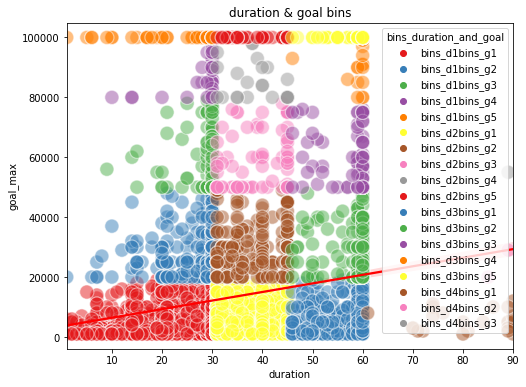

In [16]:
## raw features
def goal2feature(input_df):
    tmp = input_df["goal"]
    tmp = tmp.replace("100000+", "100000-100000")
    tmp = np.array([g.split("-") for g in tmp], dtype="int")
    output_df = pd.DataFrame(tmp, columns=["goal_min", "goal_max"])
    output_df["goal_upper_flag"] = output_df["goal_min"] == 100000
    output_df["goal_lower_flag"] = output_df["goal_min"] == 1
    output_df["goal_mean"] = output_df[["goal_min", "goal_max"]].mean(axis=1)
    output_df["goal_q25"] = output_df[["goal_min", "goal_max"]].quantile(q=0.25, axis=1)
    output_df["goal_q75"] = output_df[["goal_min", "goal_max"]].quantile(q=0.75, axis=1)
    return output_df

def get_numerical_feature(input_df):
    cols = ["duration"]
    return input_df[cols].copy()

## binning
def get_bins(input_df):
    _input_df = pd.concat([
        input_df[["duration"]],
        goal2feature(input_df),
    ], axis=1)
    output_df = pd.DataFrame()
    output_df["bins_duration"] = pd.cut(_input_df["duration"],
                                        bins=[-1, 30, 45, 60, 100],
                                        labels=['bins_d1', 'bins_d2', 'bins_d3', 'bins_d4'])
    output_df["bins_goal"] = pd.cut(_input_df["goal_max"],
                                    bins=[-1, 19999, 49999, 79999, 99999, np.inf],
                                    labels=['bins_g1', 'bins_g2', 'bins_g3', 'bins_g4', 'bins_g5'])
    return output_df.astype(str)

## visualize about bins
# binnin特徴量の閾値は下の図から得ています. durationは30, 45, 60, goalは20000, 50000, 80000, 100000で何かわかれていそうです
def show_scatterplot(input_df, x, y, hue=None, reg=True, title=None):
    plt.figure(figsize=(8, 6))
    if hue is not None:
        input_df = input_df.sort_values(hue)
    if reg:
        sns.regplot(x=x, y=y, data=input_df, scatter=False,color="red", )
    sns.scatterplot(data=input_df,x=x, y=y, hue=hue, s=200, palette='Set1', alpha=0.5)
    if title is not None:
        plt.title(title)
    plt.show()

df = pd.concat([train[["duration"]], get_bins(train), goal2feature(train)], axis=1)
df["bins_duration_and_goal"] = df["bins_duration"] + df["bins_goal"]  # duration & goal 
show_scatterplot(df, x="duration",y="goal_max", title="raw")  # plot してみると閾値がありそう -> binnig してみる
show_scatterplot(df, x="duration",y="goal_max", title="duration bins", hue="bins_duration")
show_scatterplot(df, x="duration",y="goal_max", title="goal bins", hue="bins_goal")
show_scatterplot(df, x="duration",y="goal_max", title="duration & goal bins", hue="bins_duration_and_goal")

In [14]:
## cross features
# カテゴリ変数×カテゴリ変数
def get_cross_cat_features(input_df):
    _input_df = pd.concat([
        input_df,
        get_bins(input_df)
    ], axis=1).astype(str)
    output_df = pd.DataFrame()
    output_df["category3"] = _input_df["category1"] + _input_df["category2"] 
    output_df["country+category1"] = _input_df["country"] + _input_df["category1"]
    output_df["country+category2"] = _input_df["country"] + _input_df["category2"]
    output_df["country+category3"] = _input_df["country"] + output_df["category3"]
    output_df["bins_DurationGoal"] = _input_df["bins_duration"] + _input_df["bins_goal"]
    return output_df

In [15]:
# 数値変数×数値変数
def get_cross_num_features(input_df):
    _input_df = pd.concat([
        input_df,
        goal2feature(input_df), 
    ], axis=1)
    output_df = pd.DataFrame()
    output_df["ratio_goalMax_duration"] = _input_df["goal_max"] / (_input_df["duration"] + 1)
    output_df["ratio_goalMin_duration"] = _input_df["goal_min"] / (_input_df["duration"] + 1)
    output_df["ratio_goalMean_duration"] = _input_df["goal_mean"] / (_input_df["duration"] + 1)
    output_df["prod_goalMax_duration"] = _input_df["goal_max"] * (_input_df["duration"])
    output_df["prod_goalMin_duration"] = _input_df["goal_min"] * (_input_df["duration"])
    output_df["prod_goalMean_duration"] = _input_df["goal_mean"] * (_input_df["duration"])
    return output_df

In [17]:
## count encoding
def get_ce_features(input_df):
    _input_df = pd.concat([
        input_df, 
        get_cross_cat_features(input_df),
        get_bins(input_df)
    ], axis=1).astype(str)
    cols = [
        "category1",
        "category2",
        "category3",
        "country",
        "country+category1",
        "country+category2",
        "country+category3",
        "bins_duration",
        "bins_goal",
        "bins_DurationGoal",
    ]
    encoder = ce.CountEncoder()
    output_df = encoder.fit_transform(_input_df[cols]).add_prefix("CE_")
    return output_df

In [18]:
## aggregational features
# use xfeat.aggregation
# xfeat の aggregation 関数を使ってカテゴリ変数の集約特徴量を作ります

def agg_country(input_df):
    _input_df = pd.concat([
        input_df,
        goal2feature(input_df),
        get_cross_num_features(input_df),
        get_cross_cat_features(input_df),
    ], axis=1)
    group_key = "country"  # カテゴリ変数
    group_values = [  # 集約される数値特徴量
        "goal_min",
        "goal_max",
        "goal_mean",
        "duration",
        "ratio_goalMax_duration",
        "ratio_goalMin_duration",
        "prod_goalMax_duration",
        "prod_goalMin_duration",
    ]
    agg_methods = ["min", "max", "mean", "std", "count"]  # 集約方法
    output_df, cols = xfeat.aggregation(_input_df, group_key, group_values, agg_methods)
    return output_df[cols].copy()

def agg_category1(input_df):
    _input_df = pd.concat([
        input_df,
        goal2feature(input_df),
        get_cross_num_features(input_df),
        get_cross_cat_features(input_df),
    ], axis=1)
    group_key = "category1"
    group_values = [
        "goal_min",
        "goal_max",
        "goal_mean",
        "duration",
        "ratio_goalMax_duration",
        "ratio_goalMin_duration",
        "prod_goalMax_duration",
        "prod_goalMin_duration",
    ]
    agg_methods = ["min", "max", "mean", "std", "count"]
    output_df, cols = xfeat.aggregation(_input_df, group_key, group_values, agg_methods)
    return output_df[cols].copy()

def agg_category2(input_df):
    _input_df = pd.concat([
        input_df,
        goal2feature(input_df),
        get_cross_num_features(input_df),
        get_cross_cat_features(input_df),
    ], axis=1)
    group_key = "category2"
    group_values = [
        "goal_min",
        "goal_max",
        "goal_mean",
        "duration",
        "ratio_goalMax_duration",
        "ratio_goalMin_duration",
        "prod_goalMax_duration",
        "prod_goalMin_duration",
    ]
    agg_methods = ["min", "max", "mean", "std", "count"]
    output_df, cols = xfeat.aggregation(_input_df, group_key, group_values, agg_methods)
    return output_df[cols].copy()


def agg_category3(input_df):
    _input_df = pd.concat([
        input_df,
        goal2feature(input_df),
        get_cross_num_features(input_df),
        get_cross_cat_features(input_df),
    ], axis=1)
    group_key = "category3"
    group_values = [
        "goal_min",
        "goal_max",
        "goal_mean",
        "duration",
        "ratio_goalMax_duration",
        "ratio_goalMin_duration",
        "prod_goalMax_duration",
        "prod_goalMin_duration",
    ]
    agg_methods = ["min", "max", "mean", "std", "count"]
    output_df, cols = xfeat.aggregation(_input_df, group_key, group_values, agg_methods)
    return output_df[cols].copy()

def agg_bins_duration_goal(input_df):
    _input_df = pd.concat([
        input_df,
        goal2feature(input_df),
        get_cross_num_features(input_df),
        get_cross_cat_features(input_df),
    ], axis=1)
    group_key = "bins_DurationGoal"
    group_values = [
        "goal_min",
        "goal_max",
        "goal_mean",
        "duration",
        "ratio_goalMax_duration",
        "ratio_goalMin_duration",
        "prod_goalMax_duration",
        "prod_goalMin_duration",
    ]
    agg_methods = ["min", "max", "mean", "std", "count"]
    output_df, cols = xfeat.aggregation(_input_df, group_key, group_values, agg_methods)
    return output_df[cols].copy()

In [19]:
## text features
# use text hero

# ------------------------------------------------------------ #
# text cleansing 用の関数
# texthero.clean を使って簡単にテキストの前処理(htmlタグ除去など)できる!!

def cleansing_hero_remove_html_tags(input_df, text_col):
    ## only remove html tags, do not remove punctuation
    custom_pipeline = [
        hero.preprocessing.fillna,
        hero.preprocessing.remove_html_tags,
        hero.preprocessing.lowercase,
        hero.preprocessing.remove_digits,
        hero.preprocessing.remove_stopwords,
        hero.preprocessing.remove_whitespace,
        hero.preprocessing.stem
    ]
    texts = hero.clean(input_df[text_col], custom_pipeline)
    return texts


def cleansing_hero_only_text(input_df, text_col):
    ## get only text (remove html tags, punctuation & digits)
    custom_pipeline = [
        hero.preprocessing.fillna,
        hero.preprocessing.remove_html_tags,
        hero.preprocessing.lowercase,
        hero.preprocessing.remove_digits,
        hero.preprocessing.remove_punctuation,
        hero.preprocessing.remove_diacritics,
        hero.preprocessing.remove_stopwords,
        hero.preprocessing.remove_whitespace,
        hero.preprocessing.stem
    ]
    texts = hero.clean(input_df[text_col], custom_pipeline)
    return texts
# ------------------------------------------------------------ #

# text の基本的な情報をgetする関数
def basic_text_features_transformer(input_df, text_columns, cleansing_hero=None, name=""):
    def _get_features(dataframe, column):
        _df = pd.DataFrame()
        _df[column + name + '_num_chars'] = dataframe[column].apply(len)
        _df[column + name + '_num_exclamation_marks'] = dataframe[column].apply(lambda x: x.count('!'))
        _df[column + name + '_num_question_marks'] = dataframe[column].apply(lambda x: x.count('?'))
        _df[column + name + '_num_punctuation'] = dataframe[column].apply(lambda x: sum(x.count(w) for w in '.,;:'))
        _df[column + name + '_num_symbols'] = dataframe[column].apply(lambda x: sum(x.count(w) for w in '*&$%'))
        _df[column + name + '_num_words'] = dataframe[column].apply(lambda x: len(x.split()))
        _df[column + name + '_num_unique_words'] = dataframe[column].apply(lambda x: len(set(w for w in x.split())))
        _df[column + name + '_words_vs_unique'] = _df[column + name + '_num_unique_words'] / _df[column + name + '_num_words']
        _df[column + name + '_words_vs_chars'] = _df[column + name + '_num_words'] / _df[column + name + '_num_chars']
        return _df
    
    # main の処理
    output_df = pd.DataFrame()
    output_df[text_columns] = input_df[text_columns].astype(str).fillna('missing')
    for c in text_columns:
        if cleansing_hero is not None:
            output_df[c] = cleansing_hero(output_df, c)
        output_df = _get_features(output_df, c)
    return output_df

# カウントベースの text vector をgetする関数 
def text_vectorizer(input_df, 
                    text_columns,
                    cleansing_hero=None,
                    vectorizer=CountVectorizer(),
                    transformer=TruncatedSVD(n_components=128),
                    name='html_count_svd'):
    
    output_df = pd.DataFrame()
    output_df[text_columns] = input_df[text_columns].astype(str).fillna('missing')
    features = []
    for c in text_columns:
        if cleansing_hero is not None:
            output_df[c] = cleansing_hero(output_df, c)

        sentence = vectorizer.fit_transform(output_df[c])
        feature = transformer.fit_transform(sentence)
        num_p = feature.shape[1]
        feature = pd.DataFrame(feature, columns=[name+str(num_p) + f'_{i:03}' for i in range(num_p)])
        features.append(feature)
    output_df = pd.concat(features, axis=1)
    return output_df
# ------------------------------------------------------------ #
# main の前処理関数たち

# text 前処理なしの basic features
def get_basic_text_features_raw(input_df):
    output_df = basic_text_features_transformer(input_df=input_df, text_columns=["html_content"], cleansing_hero=None)
    return output_df


# html tag 除去後の basic features
def get_basic_text_features_removed_html_tags(input_df):
    output_df = basic_text_features_transformer(input_df=input_df, 
                                                text_columns=["html_content"], 
                                                cleansing_hero=cleansing_hero_remove_html_tags, # html tag 除去の hero
                                               )
    return output_df

# text 前処理なし html_content [tfidf -> sdv で次元削減(128)]
def get_text_vector_raw__tfidf_sdv64(input_df):
    output_df = text_vectorizer(input_df,
                                ["html_content"],
                                cleansing_hero=None,
                                vectorizer=TfidfVectorizer(),
                                transformer=TruncatedSVD(n_components=64, random_state=2021),
                                name="raw_html_tfidf_sdv"
                                )
    return output_df


# html tag除去 html_content [tfidf -> sdv で次元削減(64)]
def get_text_vector_removed_htnl_tags__tfidf_sdv64(input_df):
    output_df = text_vectorizer(input_df,
                                ["html_content"],
                                cleansing_hero=cleansing_hero_remove_html_tags,  # html tag 除去の hero
                                vectorizer=TfidfVectorizer(),
                                transformer=TruncatedSVD(n_components=64, random_state=2021),
                                name="removed_tags_html_tfidf_sdv"
                                )
    return output_df


# only text html_content [tfidf -> sdv で次元削減(64)]
def get_text_vector_only_text__tfidf_sdv64(input_df):
    output_df = text_vectorizer(input_df,
                                ["html_content"],
                                vectorizer=TfidfVectorizer(),
                                cleansing_hero=cleansing_hero_only_text,  # hero
                                transformer=TruncatedSVD(n_components=64, random_state=2021),
                                name="only_text_html_tfidf_sdv"
                                )
    return output_df

In [20]:
# html_content 以外の特徴量作成
def get_process_funcs_without_text():
    funcs = [
        goal2feature,
        get_numerical_feature,
        get_ce_features,
        get_cross_num_features,
        agg_country,
        agg_category1,
        agg_category2,
        agg_category3,
        agg_bins_duration_goal,
    ]
    return funcs

# html_content 含めた特徴量作成
def get_process_funcs():
    funcs = [
        goal2feature,
        get_numerical_feature,
        get_ce_features,
        get_cross_num_features,
        agg_country,
        agg_category1,
        agg_category2,
        agg_category3,
        agg_bins_duration_goal,
        get_basic_text_features_raw,
        get_basic_text_features_removed_html_tags,
        get_text_vector_raw__tfidf_sdv64,
        get_text_vector_removed_htnl_tags__tfidf_sdv64,
        get_text_vector_only_text__tfidf_sdv64,
    ]
    return funcs

def to_feature(input_df, funcs):
    output_df = pd.DataFrame()
    for func in tqdm(funcs, total=len(funcs)):
        _df = func(input_df)
        assert len(_df) == len(input_df), func.__name__
        output_df = pd.concat([output_df, _df], axis=1)

    return output_df

In [21]:
## preprocessing
input_df = pd.concat([train, test]).reset_index(drop=True)  # このコンペではルール的に可能なので、楽するためにconcatして前処理

# without text features
process_funcs = get_process_funcs_without_text()
output_df_notext = to_feature(input_df, process_funcs)
train_x_notext = output_df_notext.iloc[:len(train)]
test_x_notext = output_df_notext.iloc[len(train):].reset_index(drop=True)

# all featrues
process_funcs = get_process_funcs()
output_df = to_feature(input_df, process_funcs)
train_x = output_df.iloc[:len(train)]
test_x = output_df.iloc[len(train):].reset_index(drop=True)

# target variable
train_y = train["state"]

print(train_x_notext.shape, train_x.shape)

100%|██████████| 14/14 [04:33<00:00, 19.54s/it]

(10545, 224) (10545, 434)


In [22]:
# 今回は stratified kfold を使ってます
# fold ごとの index を返す関数を定義

def make_skf(train_x, train_y, random_state=2021):
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=random_state)
    folds_idx = [(t, v) for (t, v) in skf.split(train_x, train_y)]
    return folds_idx

In [23]:
# 最適な閾値を求める関数
def threshold_optimization(y_true, y_pred, metrics=None):
    def f1_opt(x):
        if metrics is not None:
            score = -metrics(y_true, y_pred >= x)
        else:
            raise NotImplementedError
        return score
    result = minimize(f1_opt, x0=np.array([0.5]), method='Nelder-Mead')
    best_threshold = result['x'].item()
    return best_threshold

# 後で定義するモデルは確率で結果を出力するので、そこから最適なf1をgetする関数を定義
def optimized_f1(y_true, y_pred):
    bt = threshold_optimization(y_true, y_pred, metrics=f1_score)
    score = f1_score(y_true, y_pred >= bt)
    return score

In [24]:
# LGBMModel の wrapper
class MyLGBMModel:
    def __init__(self, name=None, params=None, fold=None, train_x=None, train_y=None, test_x=None, metrics=None, seeds=None):
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.name = name
        self.params = params
        self.metrics = metrics  # metrics で定義した関数
        self.kfold = fold  # make fold で定義した関数
        self.oof = None
        self.preds = None
        self.seeds = seeds if seeds is not None else [2020]  # seed average用のseed値
        self.models = {}  # 学習済みモデルを保持

    def build_model(self):
        model = LGBMModel(**self.params)
        return model

    def predict_cv(self):
        oof_seeds = []
        scores_seeds = []
        for seed in self.seeds:
            oof = []
            va_idxes = []
            scores = []
            train_x = self.train_x.values
            train_y = self.train_y.values
            fold_idx = self.kfold(self.train_x, self.train_y, random_state=seed) 

            # train and predict by cv folds
            for cv_num, (tr_idx, va_idx) in enumerate(fold_idx):
                tr_x, va_x = train_x[tr_idx], train_x[va_idx]
                tr_y, va_y = train_y[tr_idx], train_y[va_idx]
                va_idxes.append(va_idx)
                model = self.build_model()
    
                # fitting - train
                model.fit(tr_x, tr_y,
                          eval_set=[[va_x, va_y]],
                          early_stopping_rounds=100,
                          verbose=False)  # 今回はみやすさのためoffにしてます(お好みで)
                model_name = f"{self.name}_SEED{seed}_FOLD{cv_num}_model.pkl"
                self.models[model_name] = model  # save model
                
                # predict - validation
                pred = model.predict(va_x)
                oof.append(pred)

                # validation score
                score = self.get_score(va_y, pred)
                scores.append(score)
                print(f"SEED:{seed}, FOLD:{cv_num} =====> val_score:{score}")

            # sort as default
            va_idxes = np.concatenate(va_idxes)
            oof = np.concatenate(oof)
            order = np.argsort(va_idxes)
            oof = oof[order]
            oof_seeds.append(oof)
            scores_seeds.append(np.mean(scores))
            
        oof = np.mean(oof_seeds, axis=0)
        self.oof = oof
        print(f"model:{self.name} score:{self.get_score(self.train_y, oof)}\n")
        return oof

    def inference(self):
        preds_seeds = []
        for seed in self.seeds:
            preds = []
            test_x = self.test_x.values
            # train and predict by cv folds
            for cv_num in range(FOLDS):
                print(f"-INFERENCE- SEED:{seed}, FOLD:{cv_num}")
                # load model
                model_name = f"{self.name}_SEED{seed}_FOLD{cv_num}_model.pkl"
                model = self.models[model_name]
                # predict - test data
                pred = model.predict(test_x)
                preds.append(pred)
            preds = np.mean(preds, axis=0)
            preds_seeds.append(preds)
        preds = np.mean(preds_seeds, axis=0)
        self.preds = preds
        return preds

    def tree_importance(self):
        # visualize feature importance
        feature_importance_df = pd.DataFrame()
        for i, (tr_idx, va_idx) in enumerate(self.kfold(self.train_x, self.train_y)):
            tr_x, va_x = self.train_x.values[tr_idx], self.train_x.values[va_idx]
            tr_y, va_y = self.train_y.values[tr_idx], self.train_y.values[va_idx]
            model = self.build_model()
            model.fit(tr_x, tr_y,
                      eval_set=[[va_x, va_y]],
                      early_stopping_rounds=100,
                      verbose=False) # 今回はみやすさのためoffにしてます(お好みで)
            _df = pd.DataFrame()
            _df['feature_importance'] = model.feature_importances_
            _df['column'] = self.train_x.columns
            _df['fold'] = i + 1
            feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)
        order = feature_importance_df.groupby('column') \
                    .sum()[['feature_importance']] \
                    .sort_values('feature_importance', ascending=False).index[:50]
        fig, ax = plt.subplots(figsize=(12, max(4, len(order) * .2)))
        sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance', order=order, ax=ax,
                      palette='viridis')
        fig.tight_layout()
        ax.grid()
        ax.set_title('feature importance')
        fig.tight_layout()
        plt.show()
        return fig, feature_importance_df
    
    def get_score(self, y_true, y_pred):
        score = self.metrics(y_true, y_pred)
        return score

In [25]:
# visualize result
def visualize_confusion_matrix(y_true,
                               pred_label,
                               height=.6,
                               labels=None):
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')
    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 4, size * 3))
    sns.heatmap(conf, cmap='Blues', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

    plt.show()
    return fig

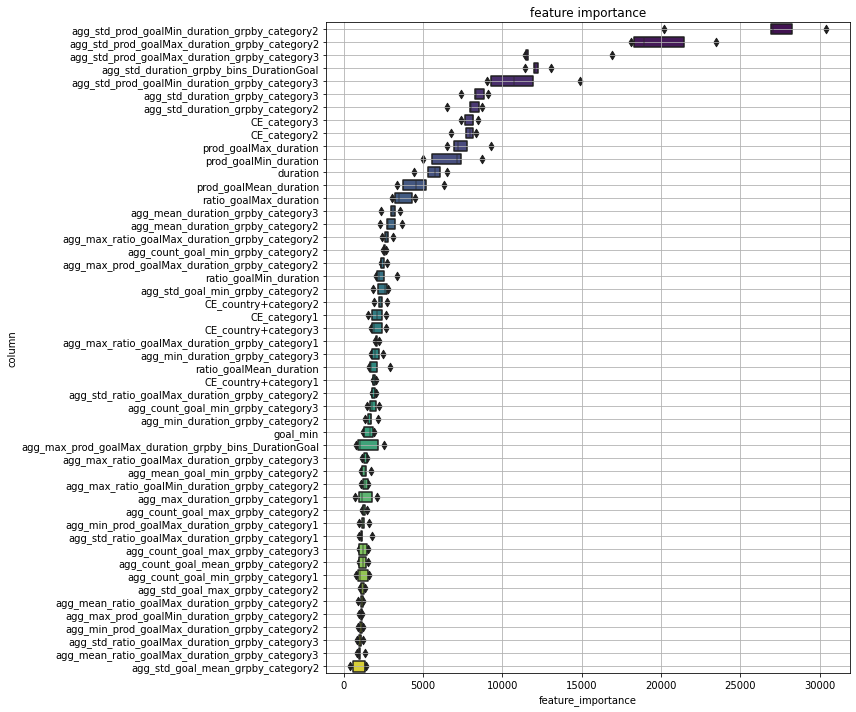

SEED:0, FOLD:0 =====> val_score:0.7680751173708921
SEED:0, FOLD:1 =====> val_score:0.7798085291557877
SEED:0, FOLD:2 =====> val_score:0.7493495229835212
SEED:0, FOLD:3 =====> val_score:0.7552388935456832
SEED:0, FOLD:4 =====> val_score:0.7655759748991484
SEED:1, FOLD:0 =====> val_score:0.7685066324347454
SEED:1, FOLD:1 =====> val_score:0.7727075184702303
SEED:1, FOLD:2 =====> val_score:0.7465127465127466
SEED:1, FOLD:3 =====> val_score:0.7560975609756097
SEED:1, FOLD:4 =====> val_score:0.7557220141489804
SEED:2, FOLD:0 =====> val_score:0.7628865979381443
SEED:2, FOLD:1 =====> val_score:0.757747708424269
SEED:2, FOLD:2 =====> val_score:0.7458432304038004
SEED:2, FOLD:3 =====> val_score:0.7673716012084593
SEED:2, FOLD:4 =====> val_score:0.760372565622354
model:baseline001 score:0.7607446169683452

-INFERENCE- SEED:0, FOLD:0
-INFERENCE- SEED:0, FOLD:1
-INFERENCE- SEED:0, FOLD:2
-INFERENCE- SEED:0, FOLD:3
-INFERENCE- SEED:0, FOLD:4
-INFERENCE- SEED:1, FOLD:0
-INFERENCE- SEED:1, FOLD:1
-INF

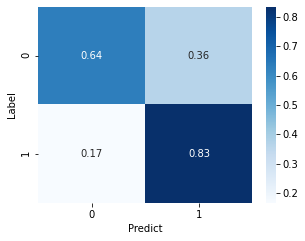

In [26]:
# define model
model_params = {
    "n_estimators": 10000,
    "objective": 'binary',
    "learning_rate": 0.01,
    "num_leaves": 31,
    "random_state": 2021,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .5,
    "reg_lambda": 5,
}
model = MyLGBMModel(name=NAME, 
                    params=model_params,
                    fold=make_skf,  # make folds
                    train_x=train_x_notext,
                    train_y=train_y,
                    test_x=test_x_notext,
                    metrics=optimized_f1, # define metrics
                    seeds=[0, 1, 2]  # 3 seeds average
                   )

# feature importance
fig, importance_df = model.tree_importance()

# feature selections
selected_num = 50  # 特徴量重要度の上位50コで学習&予測
cols = importance_df.groupby("column").mean().reset_index().sort_values("feature_importance", ascending=False)["column"].tolist()
selected_cols = cols[:selected_num]
model.train_x = model.train_x[selected_cols]
model.test_x = model.test_x[selected_cols]

# train & inference
oof_notext = model.predict_cv()  # training
preds_notext = model.inference()  # inference

# get best threshold
best_threshold = threshold_optimization(y_true=train_y, y_pred=oof_notext, metrics=f1_score) 
print(f"best_threshold is {best_threshold}\n")

# confusion matrix
visualize_confusion_matrix(y_true=train_y,
                           pred_label=oof_notext>=best_threshold)

# get pred labels
labels_notext = preds_notext >= best_threshold

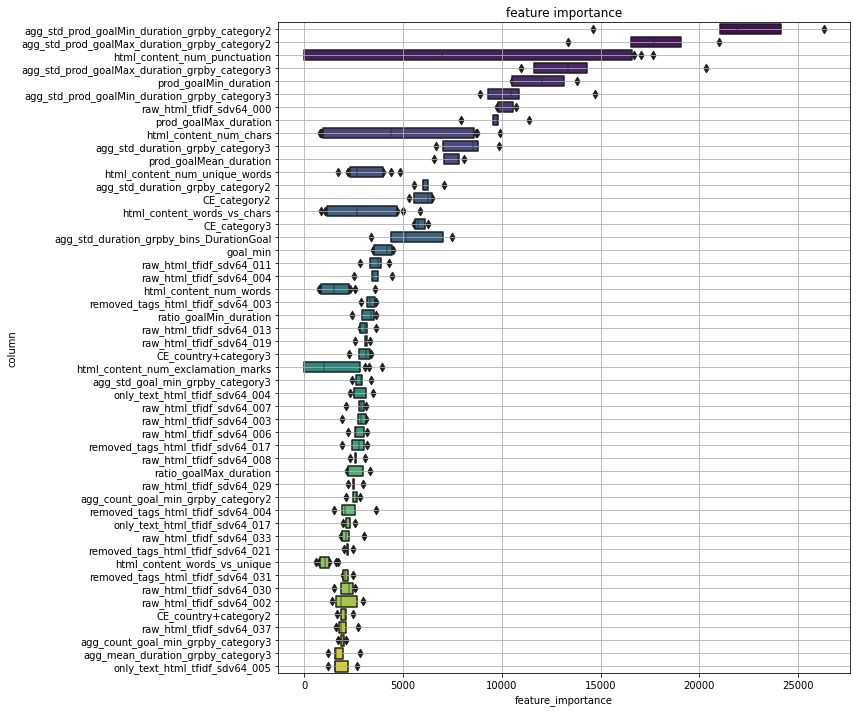

SEED:0, FOLD:0 =====> val_score:0.7962264150943397
SEED:0, FOLD:1 =====> val_score:0.8026131591227252
SEED:0, FOLD:2 =====> val_score:0.8054054054054054
SEED:0, FOLD:3 =====> val_score:0.8042870456663559
SEED:0, FOLD:4 =====> val_score:0.8045146726862301
SEED:1, FOLD:0 =====> val_score:0.8120775123929698
SEED:1, FOLD:1 =====> val_score:0.8046181172291297
SEED:1, FOLD:2 =====> val_score:0.7967479674796747
SEED:1, FOLD:3 =====> val_score:0.8140916808149407
SEED:1, FOLD:4 =====> val_score:0.7983310152990265
SEED:2, FOLD:0 =====> val_score:0.8184818481848185
SEED:2, FOLD:1 =====> val_score:0.8044485634847081
SEED:2, FOLD:2 =====> val_score:0.7984429065743944
SEED:2, FOLD:3 =====> val_score:0.8163093736864229
SEED:2, FOLD:4 =====> val_score:0.8178633975481612
model:baseline001 score:0.8089227044786442

-INFERENCE- SEED:0, FOLD:0
-INFERENCE- SEED:0, FOLD:1
-INFERENCE- SEED:0, FOLD:2
-INFERENCE- SEED:0, FOLD:3
-INFERENCE- SEED:0, FOLD:4
-INFERENCE- SEED:1, FOLD:0
-INFERENCE- SEED:1, FOLD:1
-I

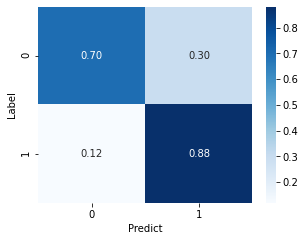

In [27]:
# define model
model_params = {
    "n_estimators": 10000,
    "objective": 'binary',
    "learning_rate": 0.01,
    "num_leaves": 31,
    "random_state": 2021,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .5,
    "reg_lambda": 5,
}
model = MyLGBMModel(name=NAME, 
                    params=model_params,
                    fold=make_skf,
                    train_x=train_x,
                    train_y=train_y,
                    test_x=test_x,
                    metrics=optimized_f1, 
                    seeds=[0, 1, 2]
                   )

# feature importance
fig, importance_df = model.tree_importance()

# feature selections
selected_num = 50
cols = importance_df.groupby("column").mean().reset_index().sort_values("feature_importance", ascending=False)["column"].tolist()
selected_cols = cols[:selected_num]
model.train_x = model.train_x[selected_cols]
model.test_x = model.test_x[selected_cols]

# train & inference
oof = model.predict_cv()  # training
preds = model.inference()  # inference

# get best threshold
best_threshold = threshold_optimization(y_true=train_y, y_pred=oof, metrics=f1_score) 
print(f"best_threshold is {best_threshold}\n")

# confusion matrix
visualize_confusion_matrix(y_true=train_y,
                           pred_label=oof>=best_threshold)

# get pred labels
labels = preds >= best_threshold

In [38]:
sample_sub = pd.read_csv('/content/drive/MyDrive/SIGNATE/DATASET/sample_submit.csv', header=None)
sub_notext = sample_sub.copy()
sub = sample_sub.copy()

# without text
sub_notext[1] = labels_notext
sub_notext = sub_notext.astype(int)
sub_notext.to_csv('notext.csv', index=False, header=False)

# within text
sub[1] = labels
sub = sub.astype(int)
sub.to_csv('text.csv', index=False, header=False)